In [2]:
import numpy as np
import seaborn as sns 

import torch
from torch import nn
import torch.optim as optim

import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.animation
from scipy.stats import multivariate_normal
from time import time
from IPython.display import display, clear_output

In [71]:
def moon_data(n):

    x,y = datasets.make_moons(n_samples=n,noise=0.1)
    t = torch.tensor(x)
    #return torch.from_numpy(x)
    return t.type(torch.FloatTensor)

In [74]:
class Generator_distribution(nn.Module):
    def __init__(self,input_dim=2):
        # initialize nn Module
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        # architecture
        self.layers.append(nn.Linear(input_dim,128))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(128,64))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(64,32))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(32,2))
        
    def forward(self,input_tensor):
        x = input_tensor
        for l in self.layers:
            x = l(x)
        return x
    
yoyo = Generator_distribution()
yoyo.forward(torch.randn(10,2))

tensor([[ 0.1226, -0.0214],
        [ 0.0946, -0.0425],
        [ 0.0966, -0.0372],
        [ 0.1026, -0.0299],
        [ 0.1077, -0.0185],
        [ 0.1010, -0.0444],
        [ 0.0962, -0.0132],
        [ 0.0968, -0.0537],
        [ 0.0904, -0.0072],
        [ 0.0931, -0.0186]], grad_fn=<AddmmBackward0>)

In [75]:
class Discriminator_distribution(nn.Module):
    def __init__(self,input_dim=2):
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        self.layers.append(nn.Linear(input_dim,128))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(128,64))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(64,32))
        self.layers.append(nn.Sigmoid())
        self.layers.append(nn.Linear(32,2))
        self.layers.append(nn.Sigmoid())
    
    def forward(self,input_tensor):
        x = input_tensor
        for l in self.layers:
            x = l(x)
        return x

yoyo = Discriminator_distribution(input_dim=2)
yoyo.forward(moon_data(10))

tensor([[0.4752, 0.5750],
        [0.4754, 0.5747],
        [0.4727, 0.5772],
        [0.4764, 0.5799],
        [0.4781, 0.5758],
        [0.4767, 0.5760],
        [0.4764, 0.5782],
        [0.4728, 0.5750],
        [0.4753, 0.5786],
        [0.4747, 0.5796]], grad_fn=<SigmoidBackward0>)

In [78]:
class GAN_distribution():
    def __init__(self,batch_size=64,n_epochs=600,lr_generator=0.00001,lr_discriminator=0.00004,from_dist=torch.randn,to_dist=moon_data):
        
        # models
        self.generator     = Generator_distribution()
        self.discriminator = Discriminator_distribution()
        
        # criterion
        self.criterion = nn.BCELoss()
        
        # optimizers
        self.optim_generator     = optim.Adam(self.generator.parameters(),    lr=lr_generator)
        self.optim_discriminator = optim.Adam(self.discriminator.parameters(),lr=lr_discriminator)
        
        # distrebutions from & to
        self.initial = from_dist
        self.real    = to_dist
        
        # batch
        self.batch_size = batch_size
            
        # epochs    
        self.n_epochs=n_epochs

        # helper for loss
        self.ones = torch.ones((batch_size, 2)) #changed to 2 
        self.zeros = torch.zeros((batch_size, 2)) #changed to 2 
        
        
    def sample_gen(self,num=1000):
        with torch.no_grad():
                return self.generator(self.initial((num,2))) #changed to 2 
     
    
    def train_step(self,epoch):
        
        loss_discriminator = self.train_step_discriminator(epoch)
        loss_generator = self.train_step_generator()

        return loss_generator,loss_discriminator
   
    
    def train_step_generator(self):
        
        self.generator.zero_grad()
        
        # gen
        sample = self.initial((self.batch_size,2)) #changed to 2 
        gen = self.generator(sample)
        cls = self.discriminator(gen)
        
        # adjusting the gen's Ws in order to fool the discriminator
        loss = self.criterion(cls,self.ones)
        loss.backward()
        self.optim_generator.step()
        return loss.item()
    
    
    def train_step_discriminator(self,epoch):

        if epoch % 2:

            self.discriminator.zero_grad()
        
            # real
            sample = self.real(self.batch_size) #changed to 2 
            pred_real = self.discriminator(sample)

            loss_real = self.criterion(pred_real,self.ones)
            
            # gen
            sample = self.initial((self.batch_size,2)) #changed to 2 
            with torch.no_grad():
                gen = self.generator(sample)
            pred_fake = self.discriminator(gen)
            loss_fake = self.criterion(pred_fake,self.zeros)
            
            # combine losses
            loss = (loss_real + loss_fake)/2
            loss.backward()
            self.optim_discriminator.step()

            return loss_real.item(),loss_fake.item()
        else:

            self.discriminator.zero_grad()
        
            # real
            sample = self.real((self.batch_size)) #changed to 2 
            pred_real = self.discriminator(sample)

            loss_real = self.criterion(pred_real,self.ones)
            
            # gen
            sample = self.initial((self.batch_size,2)) #changed to 2 
            with torch.no_grad():
                gen = self.generator(sample)
            pred_fake = self.discriminator(gen)
            loss_fake = self.criterion(pred_fake,self.zeros)
            
            # combine losses
            loss = (loss_real + loss_fake)/2
            #loss.backward()
            #self.optim_discriminator.step()
            return loss_real.item(),loss_fake.item()
    
    def train(self,verbose_instead_of_animation=False):
        self.loss_g, self.loss_d_real, self.loss_d_fake = [], [], []

        self.samples = []
        start = time()
        for epoch in range(self.n_epochs):
            
            loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
            
            for batch in range(self.batch_size):
                lg_, (ldr_, ldf_) = self.train_step(epoch)
                loss_g_running += lg_
                loss_d_real_running += ldr_
                loss_d_fake_running += ldf_
            
            self.loss_g.append(loss_g_running / self.batch_size)
            self.loss_d_real.append(loss_d_real_running / self.batch_size)
            self.loss_d_fake.append(loss_d_fake_running / self.batch_size)
            self.samples.append(self.sample_gen())
            
            if verbose_instead_of_animation and ((epoch+1)%100==0):
                print(f"Epoch {epoch+1}/{self.n_epochs} ({int(time() - start)}s):"
                      f" G={self.loss_g[-1]:.3f},"
                      f" Dr={self.loss_d_real[-1]:.3f},"
                      f" Df={self.loss_d_fake[-1]:.3f}")
        
        if not verbose_instead_of_animation:
            self.plot_animation()
        
    
    def plot(self,num=100):
        fig, ax = plt.subplots(1,2,figsize=(18,6))

        # plot Loss
        ax[0].plot(self.loss_g,label='Generator Loss')
        ax[0].plot(self.loss_d_real,label='Discriminator Loss on Real data')
        ax[0].plot(self.loss_d_fake,label='Discriminator Loss on Fake data')
        ax[0].set_title('Loss')
        ax[0].legend()

        # plot distribution
        arr = self.sample_gen(num=num).detach().numpy()
        sns.scatterplot(x=torch.flatten(self.real(num)[:,:1]).numpy(),y=torch.flatten(self.real(num)[:,1:]).numpy(), ax=ax[1], color="blue")
        sns.scatterplot(x=arr[0,:], y=arr[1,:], ax=ax[1], color="red") 
 
        ax[1].set_title('Distributions')
        ax[1].legend()
        
    def plot_animation(self):
        fig, ax = plt.subplots(1,2,figsize=(18,6))
        
        # Plot Loss
        l, = ax[0].plot([0,10],[0,2])
        l2, = ax[0].plot([0,10],[0,2])
        l3, = ax[0].plot([0,10],[0,2])
        ax[0].legend(['Generator Loss','Discriminator Loss on Real data','Discriminator Loss on Fake data'])
        ax[0].set_title('Loss')

        # Plot loss - animations functions
        t = np.arange(len(self.loss_g))
        animate_g = lambda i: l.set_data(t[:i], self.loss_g[:i])
        animate_d_real = lambda i: l2.set_data(t[:i], self.loss_d_real[:i])
        animate_d_fake = lambda i: l3.set_data(t[:i], self.loss_d_fake[:i])
        
        # Plot distribution
        num = len(self.samples[0])
        real_ = self.real(num)
        fake_ = [(torch.flatten(s[:,:1]).numpy(),torch.flatten(s[:,1:]).numpy())  for s in self.samples]

        
        
        # Plot distribution - animation function
        def animate_samples(i):
            ax[1].clear();
            current_fake_s = fake_[i]
            #sns.kdeplot(x=torch.flatten(real_[:,:1]).numpy(),y=torch.flatten(real_[:,1:]).numpy(), ax=ax[1],legend=True, levels=5,  fill=True) 
            #try:
            #    sns.kdeplot(x=current_fake_s[0], y=current_fake_s[1], ax=ax[1], legend=True, levels=5, fill=True) 
            #except ValueError:
            #    print("Could not plot fake distribution")
            sns.scatterplot(x=torch.flatten(real_[:,:1]).numpy(),y=torch.flatten(real_[:,1:]).numpy(), ax=ax[1],color="blue")
            sns.scatterplot(x=current_fake_s[0], y=current_fake_s[1], ax=ax[1], color="red")
            ax[1].legend()
            ax[1].set_title('Distributions')


            
        # Plot each epoch - Loss & distribution
        for i in range(self.n_epochs):
            # call animation functions
            animate_g(i)
            animate_d_real(i)
            animate_d_fake(i)
            animate_samples(i)
            
            # clear output anf dislay figure
            clear_output(wait=True)
            display(fig)
            
            # Plot Loss - scale the plot by new values
            ax[0].relim()
            ax[0].autoscale_view(True,True)
            
            # Plot distribution - scale the plot by new values
            ax[1].relim()
            ax[1].autoscale_view(True,True)
            
            # show entire plot
            plt.show()
        

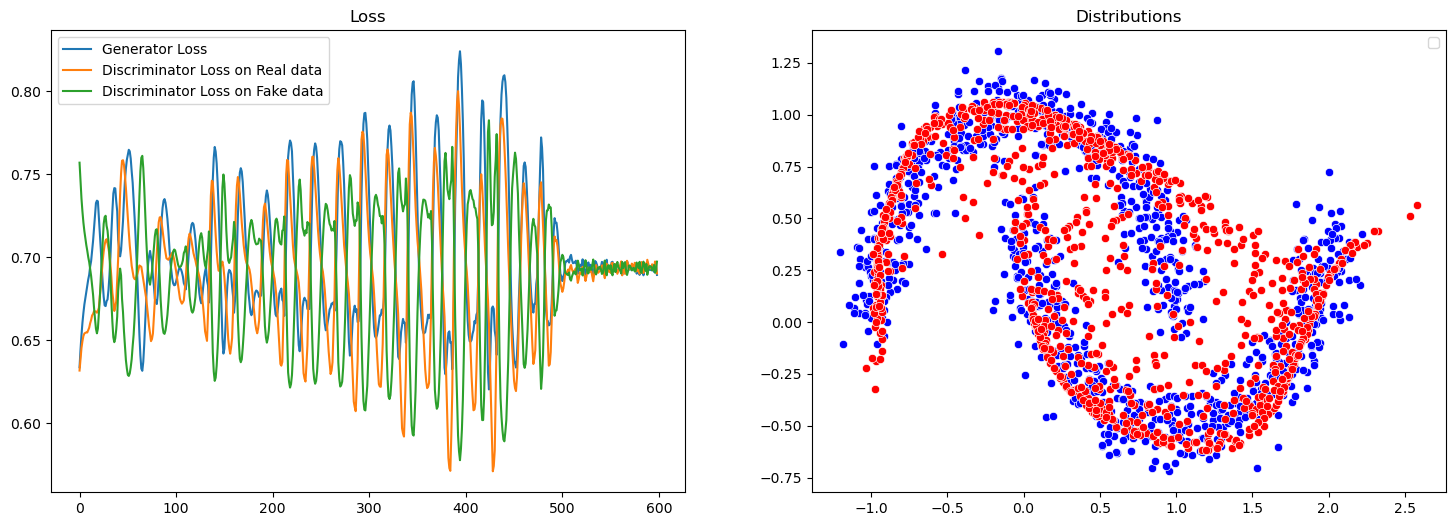

In [79]:
gan = GAN_distribution()
gan.train()